In [1]:
import jax 
import jax.numpy as jnp

import flax
import flax.linen as nn
from flax.training import train_state
import optax

import numpy as np
import st2.modules as modules

import numba

from typing import Any, Callable, Sequence, Optional, Union

import importlib

import matplotlib.pyplot as plt

import regression_utils
from regression_utils import generate_max_regression, generate_mean_regression, generate_linear_regression, generate_linear_regression_dynamic, train_step_simple, train_step_regression

## Demonstrate simple regression tasks
Obtain max and mean of a set.

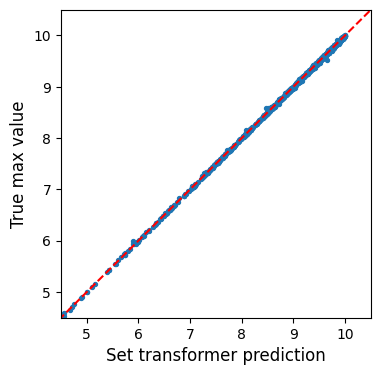

In [2]:
# max regression via set transformer
importlib.reload(modules)
importlib.reload(regression_utils)
from regression_utils import generate_max_regression, generate_mean_regression, generate_linear_regression, generate_linear_regression_dynamic, train_step_simple, train_step_regression

st = modules.SetTransformer2(
    num_layers = 2,
    num_hidden = 64,
    num_attn_heads = 4,
    num_agg_layers = 0,
    num_seeds = 1,
    layer_norm = False
)
model = nn.Sequential(
    [
        st,
        nn.Dense(1),
    ]
)
rng = jax.random.PRNGKey(0)
rng, rng_init = jax.random.split(rng, 2)
X_max, ys_max, mask_max = generate_max_regression(1000, 10, 0., 10.)
params = model.init(rng_init, X_max, mask_max[:, None, None, :])

optim = optax.adam(learning_rate = 2e-5)
state = train_state.TrainState.create(
                apply_fn=model.apply,
                params=params,
                tx=optim
            )

for i in range(5000):
    X_max, ys_max, mask_max = generate_max_regression(1000, 10, 0., 10.)
    state, loss = train_step_simple(state, X_max, ys_max, mask_max[:, None, None, :])

fig, ax = plt.subplots(figsize=(4,4))
ax.set_xlim([4.5,10.5])
ax.set_ylim([4.5,10.5])
ax.scatter(model.apply(state.params, X_max, mask_max[:, None, None, :]).squeeze(), ys_max.squeeze(), s=8)
ax.plot([4,10.5],[4,10.5],ls='--', color='red')
ax.set_xlabel('Set transformer prediction', fontsize=12)
ax.set_ylabel('True max value', fontsize=12)
plt.show()

/home/hblee/navi_working/regression_utils.py:41: RuntimeWarning: invalid value encountered in divide
  y = (X * mask).sum(axis=1) / mask.sum(axis=1)


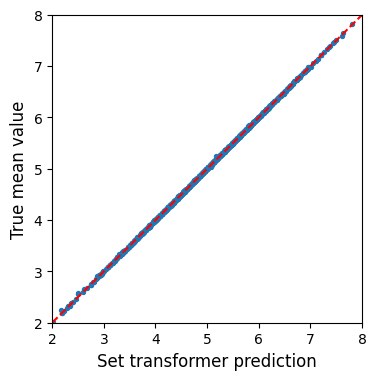

In [3]:
# mean regression via set transformer
importlib.reload(modules)
importlib.reload(regression_utils)
from regression_utils import generate_max_regression, generate_mean_regression, generate_linear_regression, generate_linear_regression_dynamic, train_step_simple, train_step_regression

st = modules.SetTransformer2(
    num_layers = 2,
    num_hidden = 64,
    num_attn_heads = 4,
    num_agg_layers = 0,
    num_seeds = 1,
    layer_norm = False
)
model = nn.Sequential(
    [
        st,
        nn.Dense(1),
    ]
)
rng = jax.random.PRNGKey(0)
rng, rng_init = jax.random.split(rng, 2)
X_max, ys_max, mask_max = generate_mean_regression(1000, 10, 0., 10.)
params = model.init(rng_init, X_max, mask_max[:, None, None, :])

optim = optax.adam(learning_rate = 1e-5)
state = train_state.TrainState.create(
                apply_fn=model.apply,
                params=params,
                tx=optim
            )

for i in range(5000):
    X_max, ys_max, mask_max = generate_mean_regression(1000, 10, 0., 10.)
    state, loss = train_step_simple(state, X_max, ys_max, mask_max[:, None, None, :])

fig, ax = plt.subplots(figsize=(4,4))
ax.set_xlim([2,8])
ax.set_ylim([2,8])
ax.scatter(model.apply(state.params, X_max, mask_max[:, None, None, :]).squeeze(), ys_max.squeeze(), s=8)
ax.plot([2,8],[2,8],ls='--', color='red')
ax.set_xlabel('Set transformer prediction', fontsize=12)
ax.set_ylabel('True mean value', fontsize=12)
plt.show()

## Demonstrate linear regression
Mimic linear regression with SetTransformer.
This is for fixed design $X$.

In [4]:
# linear regression via set transformer
num_simulations, num_samples, num_features = 1000, 50, 8
num_hidden = 64

importlib.reload(modules)
embed = modules.HiddenPadding(
    num_hidden = 64
)
st = modules.SetTransformer2(
    num_layers = 1,
    num_hidden = 64,
    num_attn_heads = 8,
    num_agg_layers = 0,
    num_seeds = num_features,
    layer_norm = False,
)

model = nn.Sequential(
    [
        embed,
        st,
        nn.Dense(1)    
    ]
)
rng = jax.random.PRNGKey(0)
rng, rng_init = jax.random.split(rng, 2)
X = np.random.normal(size=(num_samples, num_features))
bs, ys = generate_linear_regression(num_simulations, X)
# be careful when repeat!!
inputs = np.concatenate(
    (
        ys, 
        np.repeat(X[None, ...], num_simulations, axis=0).reshape(num_simulations, num_samples, num_features)
    ), axis=-1)
params = model.init(rng_init, inputs)

optim = optax.adam(learning_rate = 1e-2)
state = train_state.TrainState.create(
                apply_fn=model.apply,
                params=params,
                tx=optim
            )

for i in range(1000):
    bs, ys = generate_linear_regression(num_simulations, X)
    inputs = np.concatenate(
    (
        ys, # becareful when repeat!!
        np.repeat(X[None, ...], num_simulations, axis=0).reshape(num_simulations, num_samples, num_features)
    ), axis=-1)
    state, loss = train_step_regression(state, bs, inputs, None)
    if i % 50 == 0:
        print(loss)


1.1233443
0.24403936
0.037411366
0.03056415
0.028550807
0.027365265
0.025867792
0.025582604
0.0245944
0.023896188
0.025038509
0.024519837
0.02424696
0.024229791
0.023270948
0.023458818
0.023774816
0.023603685
0.023396
0.023327256


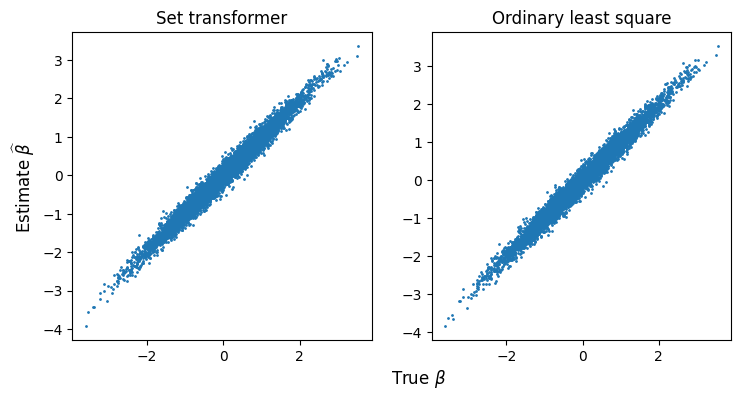

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 4))
ax[0].scatter(bs.ravel(), model.apply(state.params, inputs).ravel(), s=1)
ax[1].scatter(bs.ravel(), np.einsum('pq,nq,bnr->bpr', np.linalg.inv(X.T @ X), X, ys).ravel(), s=1)
ax[0].set_title('Set transformer', fontsize=12)
ax[1].set_title('Ordinary least square', fontsize=12)
ax[0].set_ylabel(r'Estimate $\widehat{\beta}$', fontsize=12)
fig.text(0.5, 0, r'True $\beta$', fontsize=12)
plt.show()

## Demonstrate linear regression
Mimic linear regression with SetTransformer.
This is for dynamic design $X$.

In [6]:
importlib.reload(modules)
importlib.reload(regression_utils)
from regression_utils import generate_max_regression, generate_mean_regression, generate_linear_regression, generate_linear_regression_dynamic, train_step_simple, train_step_regression

# linear regression via set transformer
num_simulations, num_samples, num_features = 400, 50, 8
num_hidden = 64

embed = modules.HiddenPadding(
    num_hidden = 64
)
st = modules.SetTransformer2(
    num_layers = 1,
    num_hidden = 64,
    num_attn_heads = 8,
    num_agg_layers = 0,
    #num_induced = 10,
    num_seeds = num_features,
    layer_norm = False,
)

model = nn.Sequential(
    [
        embed,
        st,
        nn.Dense(1)    
    ]
)
rng = jax.random.PRNGKey(0)
rng, rng_init = jax.random.split(rng, 2)
bs, ys, Xs, masks = generate_linear_regression_dynamic(num_simulations, num_samples, num_features)
# becareful when repeat!!
inputs = np.concatenate(
    (
        ys, 
        Xs
    ), axis=-1)
params = model.init(rng_init, inputs, masks[:, None, None, :])

optim = optax.adam(learning_rate = 5e-3)
state = train_state.TrainState.create(
                apply_fn=model.apply,
                params=params,
                tx=optim
            )

# a quick path to debugging is to supply a trivial case that cannot fail
for i in range(2000):
    bs, ys, Xs, masks = generate_linear_regression_dynamic(num_simulations, num_samples, num_features)
    inputs = np.concatenate(
    (
        ys, 
        Xs
    ), axis=-1)
    state, loss = train_step_regression(state, bs, inputs, masks[:, None, None, :])
    if i % 200 == 0:
        print(loss)


1.0834197
0.15530768
0.09542228
0.09008757
0.08983799
0.08188143
0.09289469
0.081491396
0.07830261
0.072414905


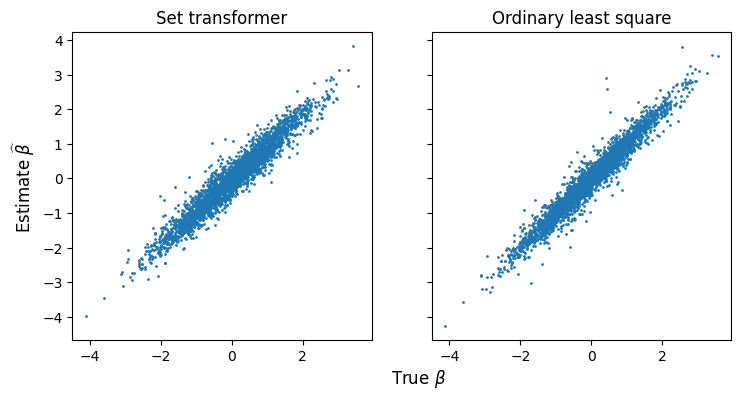

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 4), sharey=True)
ax[0].scatter(bs.ravel(), model.apply(state.params, inputs, masks[:, None, None, :]).ravel(), s=1)
ax[1].scatter(bs.ravel(), jnp.linalg.solve(np.einsum('bnp,bn,bnq->bpq', Xs, masks, Xs), np.einsum('bnp,bn,bn->bp',Xs, masks, ys.squeeze())[..., None]).ravel(), s=1)
ax[0].set_title('Set transformer', fontsize=12)
ax[1].set_title('Ordinary least square', fontsize=12)
ax[0].set_ylabel(r'Estimate $\widehat{\beta}$', fontsize=12)
fig.text(0.5, 0, r'True $\beta$', fontsize=12)
plt.show()